# Import statements 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from  my_ml_lib import MetricTools, PlotTools

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import json
import datetime
import copy
from PIL import Image as im
import joblib
from sklearn.model_selection import train_test_split
# import math as Math
import random
import torch.optim

In [12]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision

In [13]:
import cv2

# Saving and Loading code 

In [14]:
# Saving and Loading models using joblib 
def save(filename, obj):
  with open(filename, 'wb') as handle:
      joblib.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
  with open(filename, 'rb') as handle:
      return joblib.load(filename)


# Importing Dataset 

In [15]:
data_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/train.pkl"
x = load(data_path)

In [16]:
# save_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/"
# # saving the images and labels array 
# save(save_path + "data_image.pkl",data_image)
# save(save_path + "data_label.pkl",data_label)
# # dict values where labels key and image arrays as vlaues in form of list 
# save(save_path + "my_dict.pkl",my_dict)

In [17]:
save_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/"
# saving the images and labels array 
data_image = load(save_path + "data_image.pkl")
data_label = load(save_path + "data_label.pkl")
# dict values where labels key and image arrays as vlaues in form of list 
my_dict = load(save_path + "my_dict.pkl")

In [18]:
len(data_image) , len(data_label), my_dict.keys()

(5000, 5000, dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

# Data Class and Data Loaders and Data transforms 

In [19]:
len(x['names']) ,x['names'][4999] , data_image[0].shape

(5000, 'train05000', (32, 32, 3))

## Splitting the data into train and val

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data_image, data_label, test_size=0.10, random_state=42,stratify=data_label )

In [21]:
len(X_train) , len(y_train) , len(X_test) ,len(y_test)

(4500, 4500, 500, 500)

In [22]:
pd.DataFrame(y_test).value_counts() 

9    50
8    50
7    50
6    50
5    50
4    50
3    50
2    50
1    50
0    50
dtype: int64

## Data Class

In [23]:
class myDataClass(Dataset):
  """Custom dataset class"""

  def __init__(self, images, labels , transform=None):

    """
    Args:
        images : Array of all the images 
        labels : Correspoing labels of all the images 
    """
    
    self.images = images
    self.labels = labels
    self.transform = transform
    
  def __len__(self):

    return len(self.images)

  def __getitem__(self, idx):
    # converts image value between 0 and 1 and returns a tensor C,H,W 
    img = torchvision.transforms.functional.to_tensor(self.images[idx])
    target = self.labels[idx]
    

    if self.transform:
        img = self.transform(img)
    return img,target 

## Data Loaders 

In [24]:
batch = 64
train_dataset = myDataClass(X_train, y_train)
test_dataset = myDataClass(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size= batch, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size= batch, shuffle=True)

In [25]:
# next(iter(train_dataloader))[0].shape

In [26]:
len(train_dataloader) , len(test_dataloader)

(71, 8)

# Train and Test functions 

In [33]:
def load_best(all_models,model_test):
  FILE  = all_models[-1]
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model_test.parameters(), lr=0)

  checkpoint = torch.load(FILE)
  model_test.load_state_dict(checkpoint['model_state'])
  optimizer.load_state_dict(checkpoint['optim_state'])
  epoch = checkpoint['epoch']
  model_test.eval()

  return model_test


In [34]:
def train(save_path,epochs,train_dataloader,model,test_dataloader,optimizer,criterion,basic_name):
  model_no = 1
  c = 1
  all_models = []

  valid_loss_min = np.Inf 
  train_losses = []
  val_losses = []

  for e in range(epochs):

      train_loss = 0.0
      valid_loss = 0.0

      model.train()
      
      for idx, (images,labels) in enumerate(train_dataloader):
        
          images, labels = images.to(device) , labels.to(device) 
    
          optimizer.zero_grad()        
          log_ps= model(images)
          loss = criterion(log_ps, labels)
          loss.backward()
          optimizer.step()
          
          train_loss += ((1 / (idx + 1)) * (loss.data - train_loss))
      else:

          accuracy = 0
          correct = 0
          model.eval()

          with torch.no_grad():
              for idx, (images,labels) in enumerate(test_dataloader):

                  images, labels = images.to(device) , labels.to(device)

                  log_ps = model(images)
                  
                  _, predicted = torch.max(log_ps.data, 1)
                  loss = criterion(log_ps, labels)

                  # correct += (predicted == labels).sum().item()
                  equals = predicted == labels.view(*predicted.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor))
                  valid_loss += ((1 / (idx + 1)) * (loss.data - valid_loss))

          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
              e+1, 
              train_loss,
              valid_loss
              ), "Test Accuracy: {:.3f}".format(accuracy/len(test_dataloader)))

          train_losses.append(train_loss)
          val_losses.append(valid_loss)

          if valid_loss < valid_loss_min:
            
            print('Saving model..' + str(model_no))
            valid_loss_min = valid_loss

            checkpoint = {
            "epoch": e+1,
            "model_state": model.state_dict(),
            "optim_state": optimizer.state_dict(),
            "train_losses": train_losses,
            "test_losses": val_losses,
            }

            FILE =  save_path + basic_name +"_epoch_" + str(e+1) + "_model_" +  str(model_no)
            all_models.append(FILE)
            torch.save(checkpoint, FILE)
            model_no = model_no + 1
          
  
  save(save_path + basic_name + "_all_models.pkl", all_models)
  return model, train_losses, val_losses, all_models 
   

In [35]:
def plot(train_losses,val_losses,title='Training Validation Loss with CNN'):
  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.legend()
  _ = plt.ylim()
  plt.title(title)
  # plt.savefig('plots/Training Validation Loss with CNN from scratch.png')
  plt.show()

In [36]:
def test(loader, model, criterion, device, name):
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    
    model.eval()
    for batch_idx, (images, labels) in enumerate(loader):

        # move to GPU or CPU
        images, labels = images.to(device)   , labels.to(device) 
        target = labels

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        loss = criterion(output,labels)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]

        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())


        correct += np.sum(pred.view_as(labels).cpu().numpy() == labels.cpu().numpy())
        total = total + images.size(0)
        # if batch_idx % 20 == 0:
        #     print("done till batch" , batch_idx+1)
            
    print(name + ' Loss: {:.6f}\n'.format(test_loss))

    print(name + ' Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    return y, y_hat

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
# def train(save_path,epochs,train_dataloader,model,test_dataloader,optimizer,criterion,basic_name)
# def plot(train_losses,val_losses,title='Training Validation Loss with CNN')
# def test(loader, model, criterion, device)

# Tanh [ X=2 Y=3 Z=1 ] 

## CNN - Block-1 

### model 

In [39]:
cfg1 = {
    'B1': [16,16,'M'],
}

In [40]:
def make_layers1(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=4, stride=3)]
        elif v == 'M1':
            layers += [nn.MaxPool2d(kernel_size=2, stride=(1,2),padding=(0,1))]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.Tanh()]
            else:
                layers += [conv2d, nn.Tanh()]
            in_channels = v

    return nn.Sequential(*layers)

In [41]:
class Model_B1(nn.Module):

    def __init__(self, features):

        super(Model_B1, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(1600, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 64),
            nn.Tanh(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [42]:
m = Model_B1(make_layers1(cfg1['B1']))
for i,l in train_dataloader:
  o = m(i)

In [43]:
model1 = Model_B1(make_layers1(cfg1['B1'])).to(device) 
learning_rate = 0.01
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
print(model1)

Model_B1(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1600, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


###train

In [ ]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block1_t/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block1_t/'

In [44]:
save_path1 = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block1_t/"

In [45]:

# /content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block123
# /content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block12
# /content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block1

m, train_losses, val_losses,m_all_models = train(save_path1,100,train_dataloader,model1,test_dataloader,optimizer1,criterion1,"cnn_b1")

Epoch: 1 	Training Loss: 1.736322 	Validation Loss: 2.027061 Test Accuracy: 0.359
Saving model..1
Epoch: 2 	Training Loss: 1.496064 	Validation Loss: 1.647982 Test Accuracy: 0.417
Saving model..2
Epoch: 3 	Training Loss: 1.414472 	Validation Loss: 1.608373 Test Accuracy: 0.465
Saving model..3
Epoch: 4 	Training Loss: 1.403000 	Validation Loss: 1.613007 Test Accuracy: 0.448
Epoch: 5 	Training Loss: 1.375184 	Validation Loss: 1.569150 Test Accuracy: 0.465
Saving model..4
Epoch: 6 	Training Loss: 1.349748 	Validation Loss: 1.579412 Test Accuracy: 0.461
Epoch: 7 	Training Loss: 1.381629 	Validation Loss: 1.644070 Test Accuracy: 0.412
Epoch: 8 	Training Loss: 1.360971 	Validation Loss: 1.657652 Test Accuracy: 0.446
Epoch: 9 	Training Loss: 1.361623 	Validation Loss: 1.443083 Test Accuracy: 0.497
Saving model..5
Epoch: 10 	Training Loss: 1.305830 	Validation Loss: 1.361817 Test Accuracy: 0.509
Saving model..6
Epoch: 11 	Training Loss: 1.284005 	Validation Loss: 1.473130 Test Accuracy: 0.513


### Plots and test 

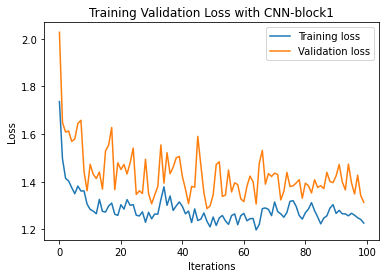

In [46]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1')

In [47]:
all_models1 = load(save_path1 + "cnn_b1_all_models.pkl")
FILE  = all_models1[-1]
m = Model_B1(make_layers1(cfg1['B1'])).to(device) 

In [48]:
m = load_best(all_models1,m)

In [49]:
train_y, train_y_hat = test(train_dataloader, m, criterion1, device, "TRAIN")

TRAIN Loss: 1.200912

TRAIN Accuracy: 57% (2601/4500)


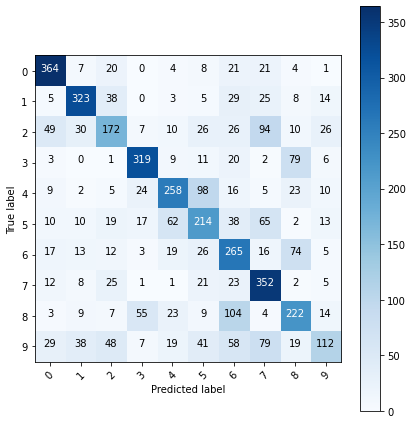

In [50]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [51]:
test_y, test_y_hat = test(test_dataloader, m, criterion1, device,"TEST")

TEST Loss: 1.292314

TEST Accuracy: 53% (265/500)


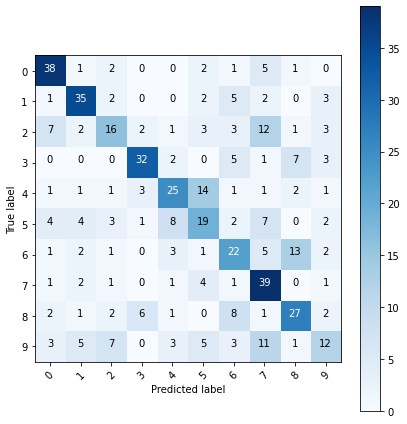

In [52]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

## CNN-Block12

### model 

In [53]:
cfg2 = {
    'B12': [16,16,'M', 32, 32, 32,'M'],
}

In [54]:
def make_layers2(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'M1':
            layers += [nn.MaxPool2d(kernel_size=2, stride=1,padding=1)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.Tanh()]
            else:
                layers += [conv2d, nn.Tanh()]
            in_channels = v

    return nn.Sequential(*layers)

In [55]:
class Model_B12(nn.Module):
    '''
        Model
    '''
    def __init__(self, features):

        super(Model_B12, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            # nn.Linear(3200, 512),
            # nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 64),
            nn.Tanh(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [56]:
# m = Model_B12(make_layers2(cfg2['B12']))
# for i,l in train_dataloader:
#   o = m(i)

In [57]:
model2 = Model_B12(make_layers2(cfg2['B12'])).to(device) 
learning_rate = 0.01
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
print(model2)

Model_B12(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Tanh()
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Tanh()
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Tanh()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

### Train 

In [58]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block12_t/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block12_t/'

In [59]:
save_path2 = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block12_t/"

In [60]:
m, train_losses, val_losses,m_all_models = train(save_path2,100,train_dataloader,model2,test_dataloader,optimizer2,criterion2,"cnn_b12")

Epoch: 1 	Training Loss: 1.891458 	Validation Loss: 2.228231 Test Accuracy: 0.233
Saving model..1
Epoch: 2 	Training Loss: 1.704404 	Validation Loss: 2.026276 Test Accuracy: 0.308
Saving model..2
Epoch: 3 	Training Loss: 1.642342 	Validation Loss: 1.767895 Test Accuracy: 0.390
Saving model..3
Epoch: 4 	Training Loss: 1.531772 	Validation Loss: 1.557709 Test Accuracy: 0.441
Saving model..4
Epoch: 5 	Training Loss: 1.465140 	Validation Loss: 1.778787 Test Accuracy: 0.401
Epoch: 6 	Training Loss: 1.418546 	Validation Loss: 1.791498 Test Accuracy: 0.391
Epoch: 7 	Training Loss: 1.368654 	Validation Loss: 1.558042 Test Accuracy: 0.468
Epoch: 8 	Training Loss: 1.364071 	Validation Loss: 1.589050 Test Accuracy: 0.452
Epoch: 9 	Training Loss: 1.284731 	Validation Loss: 1.678693 Test Accuracy: 0.425
Epoch: 10 	Training Loss: 1.339115 	Validation Loss: 1.714143 Test Accuracy: 0.422
Epoch: 11 	Training Loss: 1.332302 	Validation Loss: 1.362757 Test Accuracy: 0.503
Saving model..5
Epoch: 12 	Train

### Test and Plots 

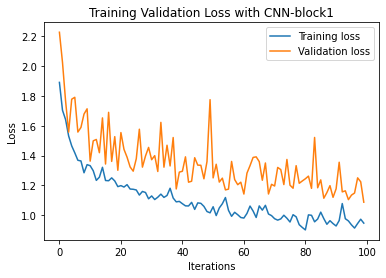

In [61]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1')

In [62]:
all_models2 = load(save_path2 + "cnn_b12_all_models.pkl")
FILE  = all_models2[-1]
m2 = Model_B12(make_layers2(cfg2['B12'])).to(device) 

In [63]:
m2 = load_best(all_models2,m2)

In [64]:
train_y, train_y_hat = test(train_dataloader, m2, criterion2, device, "TRAIN")

TRAIN Loss: 0.894667

TRAIN Accuracy: 69% (3119/4500)


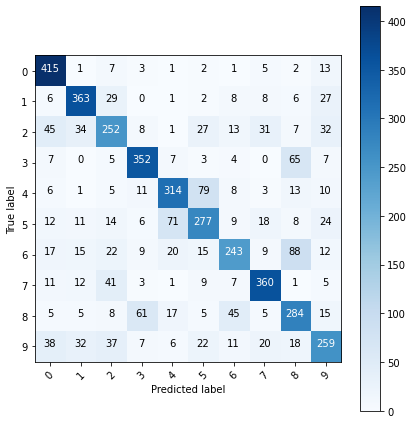

In [65]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [66]:
test_y, test_y_hat = test(test_dataloader, m2, criterion2, device,"TEST")

TEST Loss: 1.089120

TEST Accuracy: 61% (306/500)


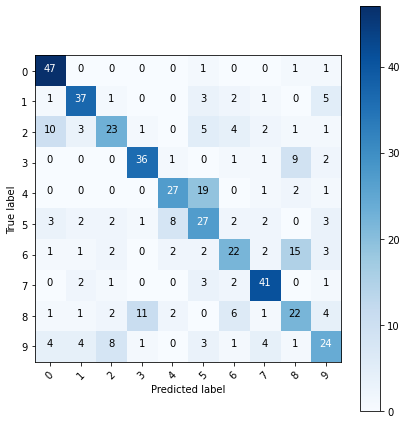

In [67]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

## CNN-Block-123

### model 

In [68]:
cfg3 = {
    'B123': [16,16,'M',32,32,32,'M',64,'M'],
}

In [69]:
def make_layers3(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'M1':
            layers += [nn.MaxPool2d(kernel_size=2, stride=1)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.Tanh()]
            else:
                layers += [conv2d, nn.Tanh()]
            in_channels = v

    return nn.Sequential(*layers)

In [70]:
class Model_B123(nn.Module):
    '''
        Model
    '''
    def __init__(self, features):

        super(Model_B123, self).__init__()
        self.features = features 

        self.classifier = nn.Sequential(
            # nn.Linear(1024, 512),
            # nn.Tanh(),
            # nn.Linear(512, 256),
            # nn.Tanh(),
            # nn.Linear(256, 64),
            # nn.Tanh(),
            nn.Linear(64, 10),
        )
       
    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        
        x = self.classifier(x)
        return x

In [71]:
# m = Model_B123(make_layers3(cfg3['B123']))
# for i,l in train_dataloader:
#   o = m(i)

In [72]:
model3 = Model_B123(make_layers3(cfg3['B123'])).to(device) 
learning_rate = 0.01
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)
print(model3)

Model_B123(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Tanh()
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Tanh()
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Tanh()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

### train 

In [73]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block123_t/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block123_t/'

In [74]:
save_path3 = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block123_t/"

In [75]:
m, train_losses, val_losses,m_all_models = train(save_path3,100,train_dataloader,model3,test_dataloader,optimizer3,criterion3,"cnn_b123")

Epoch: 1 	Training Loss: 1.712020 	Validation Loss: 1.668610 Test Accuracy: 0.383
Saving model..1
Epoch: 2 	Training Loss: 1.397537 	Validation Loss: 1.682891 Test Accuracy: 0.423
Epoch: 3 	Training Loss: 1.220684 	Validation Loss: 1.367207 Test Accuracy: 0.508
Saving model..2
Epoch: 4 	Training Loss: 1.116630 	Validation Loss: 1.343227 Test Accuracy: 0.537
Saving model..3
Epoch: 5 	Training Loss: 1.027836 	Validation Loss: 1.250082 Test Accuracy: 0.562
Saving model..4
Epoch: 6 	Training Loss: 0.957379 	Validation Loss: 1.325486 Test Accuracy: 0.511
Epoch: 7 	Training Loss: 0.878207 	Validation Loss: 0.988291 Test Accuracy: 0.648
Saving model..5
Epoch: 8 	Training Loss: 0.786177 	Validation Loss: 1.293935 Test Accuracy: 0.558
Epoch: 9 	Training Loss: 0.782564 	Validation Loss: 1.939113 Test Accuracy: 0.449
Epoch: 10 	Training Loss: 0.756114 	Validation Loss: 1.063776 Test Accuracy: 0.610
Epoch: 11 	Training Loss: 0.688585 	Validation Loss: 1.062207 Test Accuracy: 0.621
Epoch: 12 	Train

### Tests and Plots 

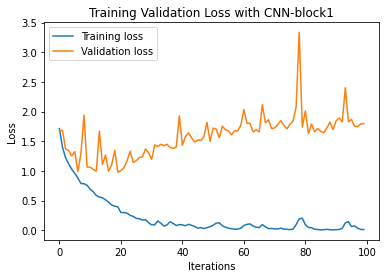

In [76]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1')

In [77]:
all_models3 = load(save_path3 + "cnn_b123_all_models.pkl")
FILE  = all_models3[-1]
m3 = Model_B123(make_layers3(cfg3['B123'])).to(device) 

In [78]:
m3 = load_best(all_models3,m3)

In [79]:
train_y, train_y_hat = test(train_dataloader, m3, criterion3, device, "TRAIN")

TRAIN Loss: 0.301188

TRAIN Accuracy: 89% (4024/4500)


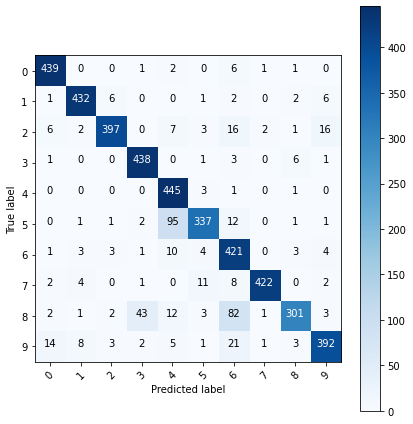

In [80]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [81]:
test_y, test_y_hat = test(test_dataloader, m3, criterion3, device,"TEST")

TEST Loss: 0.963042

TEST Accuracy: 67% (338/500)


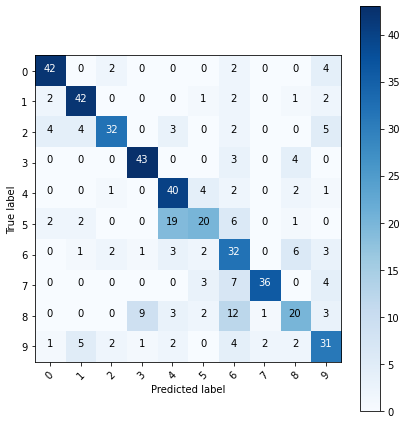

In [82]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))